### Random Forest Analysis

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

In [23]:
data = pd.read_csv("Airline_Delay_Cause.csv")
data.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2023,8,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",89.0,13.0,2.25,1.60,...,0.0,5.99,2.0,1.0,1375.0,71.0,761.0,118.0,0.0,425.0
1,2023,8,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",62.0,10.0,1.97,0.04,...,0.0,7.42,0.0,1.0,799.0,218.0,1.0,62.0,0.0,518.0
2,2023,8,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",62.0,10.0,2.73,1.18,...,0.0,4.28,1.0,0.0,766.0,56.0,188.0,78.0,0.0,444.0
3,2023,8,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",66.0,12.0,3.69,2.27,...,0.0,1.57,1.0,1.0,1397.0,471.0,320.0,388.0,0.0,218.0
4,2023,8,9E,Endeavor Air Inc.,ALB,"Albany, NY: Albany International",92.0,22.0,7.76,0.00,...,0.0,11.28,2.0,0.0,1530.0,628.0,0.0,134.0,0.0,768.0


Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Training Accuracy: 0.9246347461304788

Test Accuracy: 0.6742840613248481

Classification Report:
                   precision    recall  f1-score   support

      carrier_ct       0.68      0.78      0.73      1637
late_aircraft_ct       0.69      0.65      0.67      1198
          nas_ct       0.59      0.45      0.51       610
      weather_ct       0.00      0.00      0.00        12

        accuracy                           0.67      3457
       macro avg       0.49      0.47      0.48      3457
    weighted avg       0.67      0.67      0.67      3457



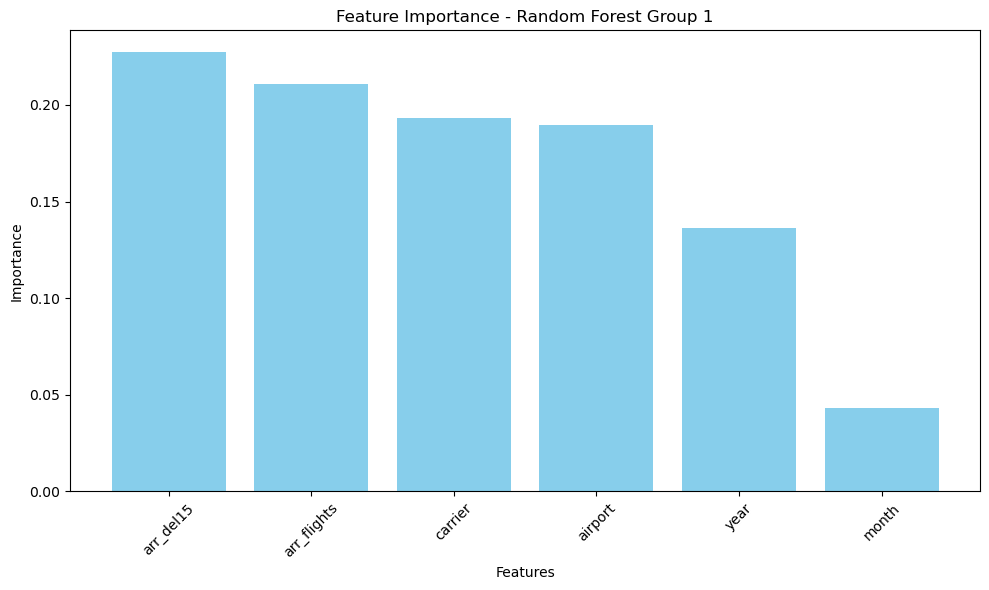

In [24]:
# Group 1 (Top 6 Airlines + Holiday Season)
data = pd.read_csv("Airline_Delay_Cause.csv")

top_6_airlines = ['DL', 'AA', 'UA', 'WN', 'AS', 'B6']
holiday_months = [7, 8, 12]

data = data[data['carrier'].isin(top_6_airlines) & data['month'].isin(holiday_months)].copy()

delay_cols = ['carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct']
data[delay_cols] = data[delay_cols].fillna(0)
data['delay_reason'] = data[delay_cols].idxmax(axis=1)

X = data[['year', 'month', 'arr_flights', 'arr_del15', 'carrier', 'airport']]
y = data['delay_reason']

threshold = 2
rare_classes = y.value_counts()[y.value_counts() < threshold].index
y = y.replace(rare_classes, 'Other')

min_samples = 5
valid_classes = y.value_counts()[y.value_counts() >= min_samples].index
filtered_indices = y.index[y.isin(valid_classes)]

X = X.loc[filtered_indices.intersection(X.index)]
y = y.loc[filtered_indices.intersection(y.index)]

num_cols = X.select_dtypes(include=['float64', 'int64']).columns
imputer_num = SimpleImputer(strategy='median')
X.loc[:, num_cols] = imputer_num.fit_transform(X[num_cols])

categorical_cols = ['carrier', 'airport']
label_encoders = {col: LabelEncoder() for col in categorical_cols}

for col in categorical_cols:
    X.loc[:, col] = label_encoders[col].fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini']
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=11),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=2,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)

best_params_rf = grid_search_rf.best_params_
best_rf_model = grid_search_rf.best_estimator_

print("\nBest Hyperparameters:", best_params_rf)

y_pred_rf_train = best_rf_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_rf_train)
print("\nTraining Accuracy:", train_accuracy)

y_pred_rf = best_rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_rf)
print("\nTest Accuracy:", test_accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))

feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.title("Feature Importance - Random Forest Group 1")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

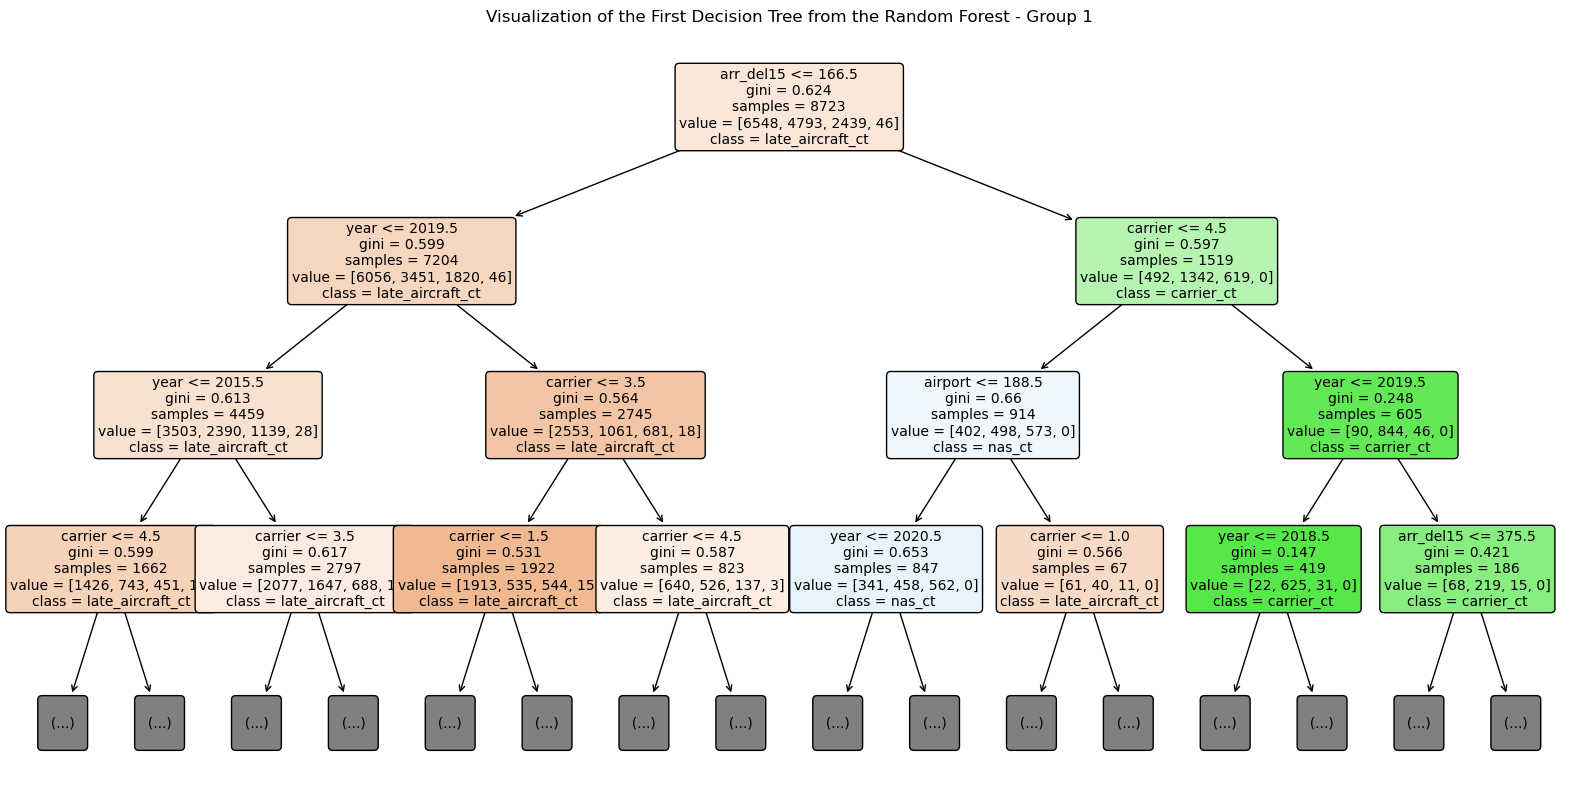

In [25]:
# Visualize the first decision tree from the Random Forest (Group 1)
plt.figure(figsize=(20, 10))
plot_tree(
    best_rf_model.estimators_[0],
    feature_names=X.columns,
    class_names=y.unique(),
    filled=True, 
    rounded=True,
    fontsize=10,
    max_depth=3
)
plt.title("Visualization of the First Decision Tree from the Random Forest - Group 1")
plt.show()

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Training Accuracy: 0.9020235655737705

Test Accuracy: 0.6067746686303387

Classification Report:
                   precision    recall  f1-score   support

      carrier_ct       0.65      0.76      0.70      6966
late_aircraft_ct       0.56      0.53      0.55      4586
          nas_ct       0.56      0.44      0.49      3879
     security_ct       0.00      0.00      0.00         5
      weather_ct       0.00      0.00      0.00       181

        accuracy                           0.61     15617
       macro avg       0.35      0.35      0.35     15617
    weighted avg       0.59      0.61      0.60     15617



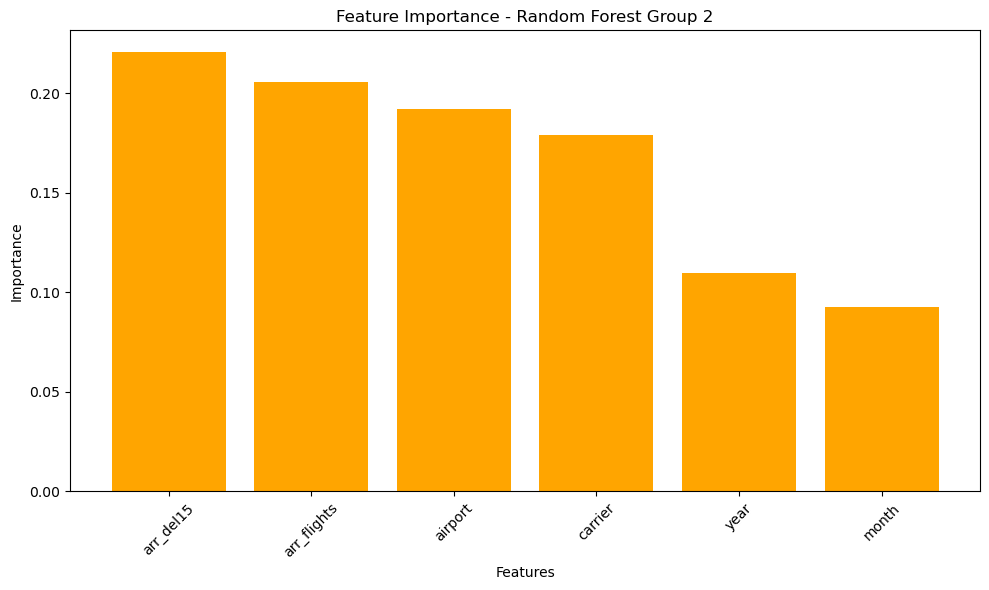

In [26]:
# Group 2 (Non-Top Airlines + Non-Holiday Season)
data = pd.read_csv("Airline_Delay_Cause.csv")

non_top_airlines = ['9E', 'F9', 'G4', 'HA', 'MQ', 'NK', 'OH', 'OO', 'QX', 'YV', 'EV', 'VX', 'US', 'FL', 'YX']
non_holiday_months = [1, 2, 3, 4, 5, 6, 9, 10, 11]

data = data[data['carrier'].isin(non_top_airlines) & data['month'].isin(non_holiday_months)].copy()

delay_cols = ['carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct']
data[delay_cols] = data[delay_cols].fillna(0)
data['delay_reason'] = data[delay_cols].idxmax(axis=1)

X = data[['year', 'month', 'arr_flights', 'arr_del15', 'carrier', 'airport']]
y = data['delay_reason']

threshold = 2
rare_classes = y.value_counts()[y.value_counts() < threshold].index
y = y.replace(rare_classes, 'Other')

min_samples = 5
valid_classes = y.value_counts()[y.value_counts() >= min_samples].index
filtered_indices = y.index[y.isin(valid_classes)]

X = X.loc[filtered_indices.intersection(X.index)]
y = y.loc[filtered_indices.intersection(y.index)]

num_cols = X.select_dtypes(include=['float64', 'int64']).columns
imputer_num = SimpleImputer(strategy='median')
X.loc[:, num_cols] = imputer_num.fit_transform(X[num_cols])

categorical_cols = ['carrier', 'airport']
label_encoders = {col: LabelEncoder() for col in categorical_cols}

for col in categorical_cols:
    X.loc[:, col] = label_encoders[col].fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini']
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=11),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=2,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)

best_params_rf = grid_search_rf.best_params_
best_rf_model = grid_search_rf.best_estimator_

print("\nBest Hyperparameters:", best_params_rf)

y_pred_rf_train = best_rf_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_rf_train)
print("\nTraining Accuracy:", train_accuracy)

y_pred_rf = best_rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_rf)
print("\nTest Accuracy:", test_accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))

feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importances['feature'], feature_importances['importance'], color='orange')
plt.title("Feature Importance - Random Forest Group 2")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

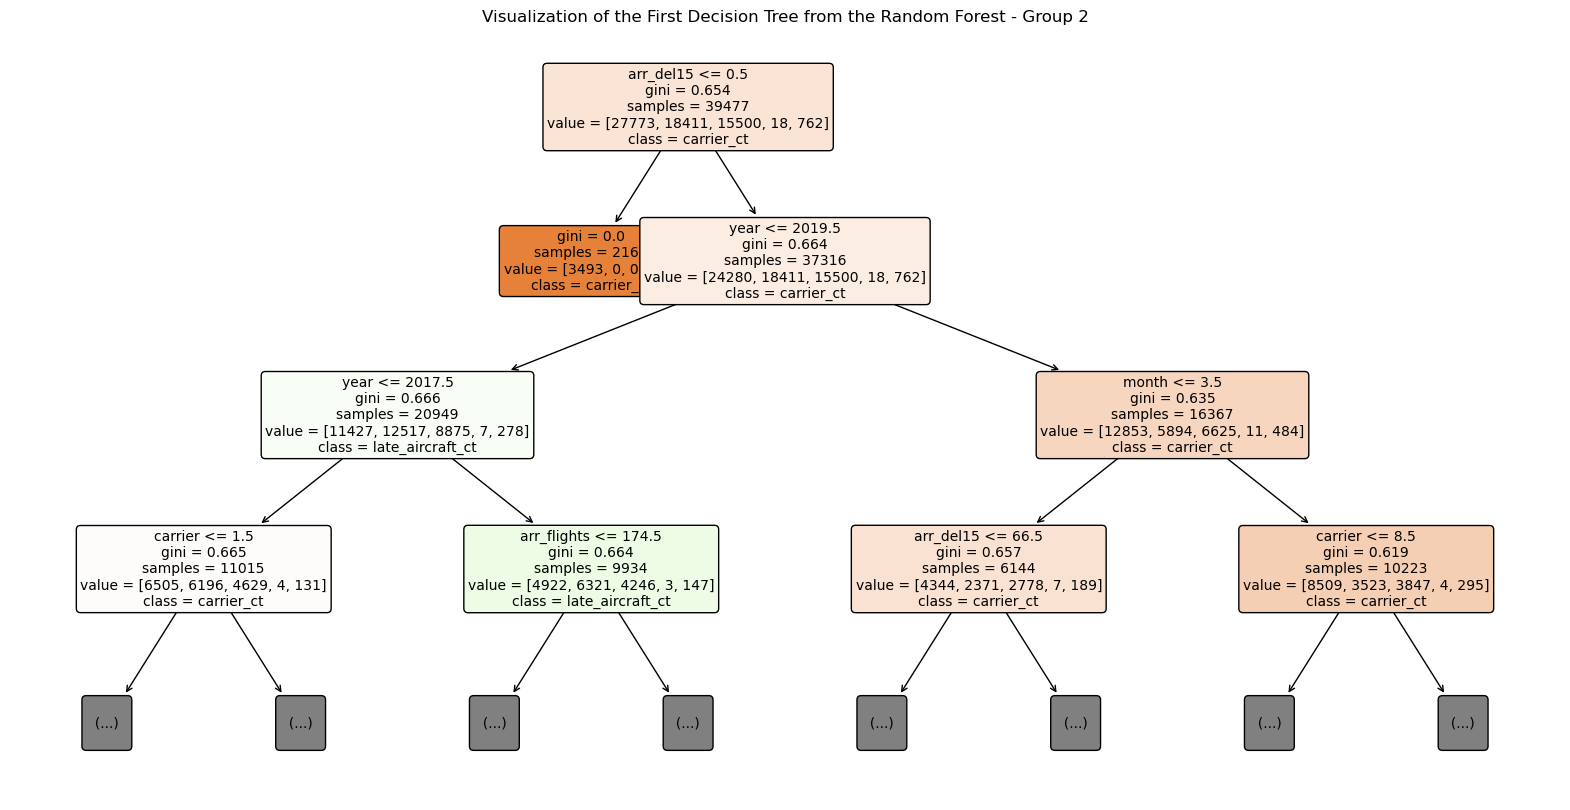

In [27]:
# Visualize the first decision tree from the Random Forest (Group 2)
plt.figure(figsize=(20, 10))
plot_tree(
    best_rf_model.estimators_[0],
    feature_names=X.columns,
    class_names=y.unique(),
    filled=True, 
    rounded=True,
    fontsize=10,
    max_depth=3
)
plt.title("Visualization of the First Decision Tree from the Random Forest - Group 2")
plt.show()

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Training Accuracy: 0.8953503040088806

Test Accuracy: 0.6849646821392533

Classification Report:
                   precision    recall  f1-score   support

      carrier_ct       0.68      0.83      0.75      4931
late_aircraft_ct       0.70      0.59      0.64      2863
          nas_ct       0.66      0.47      0.55      2064
     security_ct       0.00      0.00      0.00         3
      weather_ct       0.00      0.00      0.00        49

        accuracy                           0.68      9910
       macro avg       0.41      0.38      0.39      9910
    weighted avg       0.68      0.68      0.67      9910



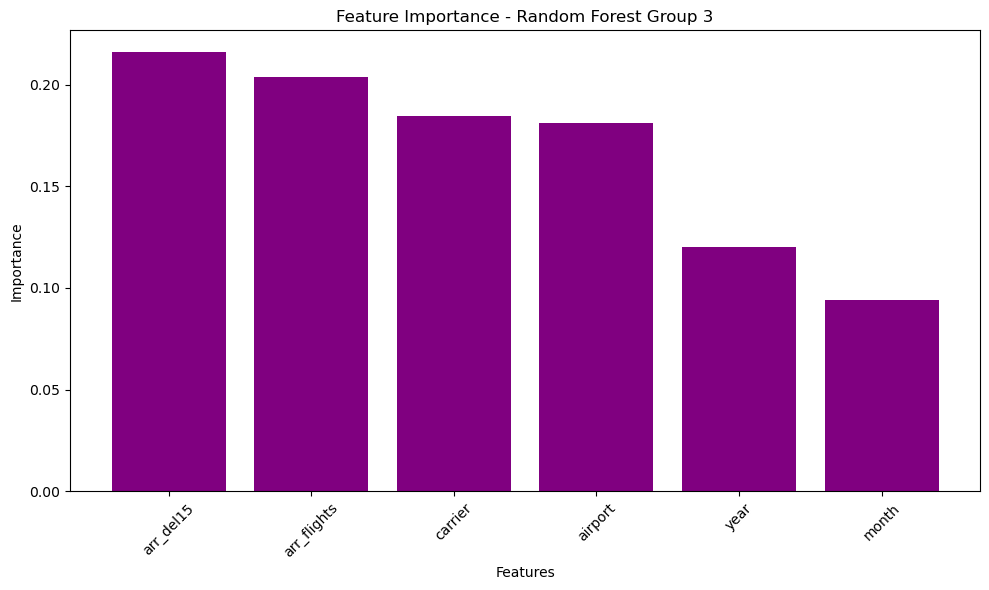

In [28]:
# Group 3 (Top 6 Airlines and Non-Holiday Season)
data = pd.read_csv("Airline_Delay_Cause.csv")

top_6_airlines = ['DL', 'AA', 'UA', 'WN', 'AS', 'B6']
non_holiday_months = [1, 2, 3, 4, 5, 6, 9, 10, 11]

data = data[data['carrier'].isin(top_6_airlines) & data['month'].isin(non_holiday_months)].copy()

delay_cols = ['carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct']
data[delay_cols] = data[delay_cols].fillna(0)
data['delay_reason'] = data[delay_cols].idxmax(axis=1)

X = data[['year', 'month', 'arr_flights', 'arr_del15', 'carrier', 'airport']]
y = data['delay_reason']

threshold = 2
rare_classes = y.value_counts()[y.value_counts() < threshold].index
y = y.replace(rare_classes, 'Other')

min_samples = 5
valid_classes = y.value_counts()[y.value_counts() >= min_samples].index
filtered_indices = y.index[y.isin(valid_classes)]

X = X.loc[filtered_indices.intersection(X.index)]
y = y.loc[filtered_indices.intersection(y.index)]

num_cols = X.select_dtypes(include=['float64', 'int64']).columns
imputer_num = SimpleImputer(strategy='median')
X.loc[:, num_cols] = imputer_num.fit_transform(X[num_cols])

categorical_cols = ['carrier', 'airport']
label_encoders = {col: LabelEncoder() for col in categorical_cols}

for col in categorical_cols:
    X.loc[:, col] = label_encoders[col].fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini']
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=11),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=2,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)

best_params_rf = grid_search_rf.best_params_
best_rf_model = grid_search_rf.best_estimator_

print("\nBest Hyperparameters:", best_params_rf)

y_pred_rf_train = best_rf_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_rf_train)
print("\nTraining Accuracy:", train_accuracy)

y_pred_rf = best_rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_rf)
print("\nTest Accuracy:", test_accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))

feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importances['feature'], feature_importances['importance'], color='purple')
plt.title("Feature Importance - Random Forest Group 3")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

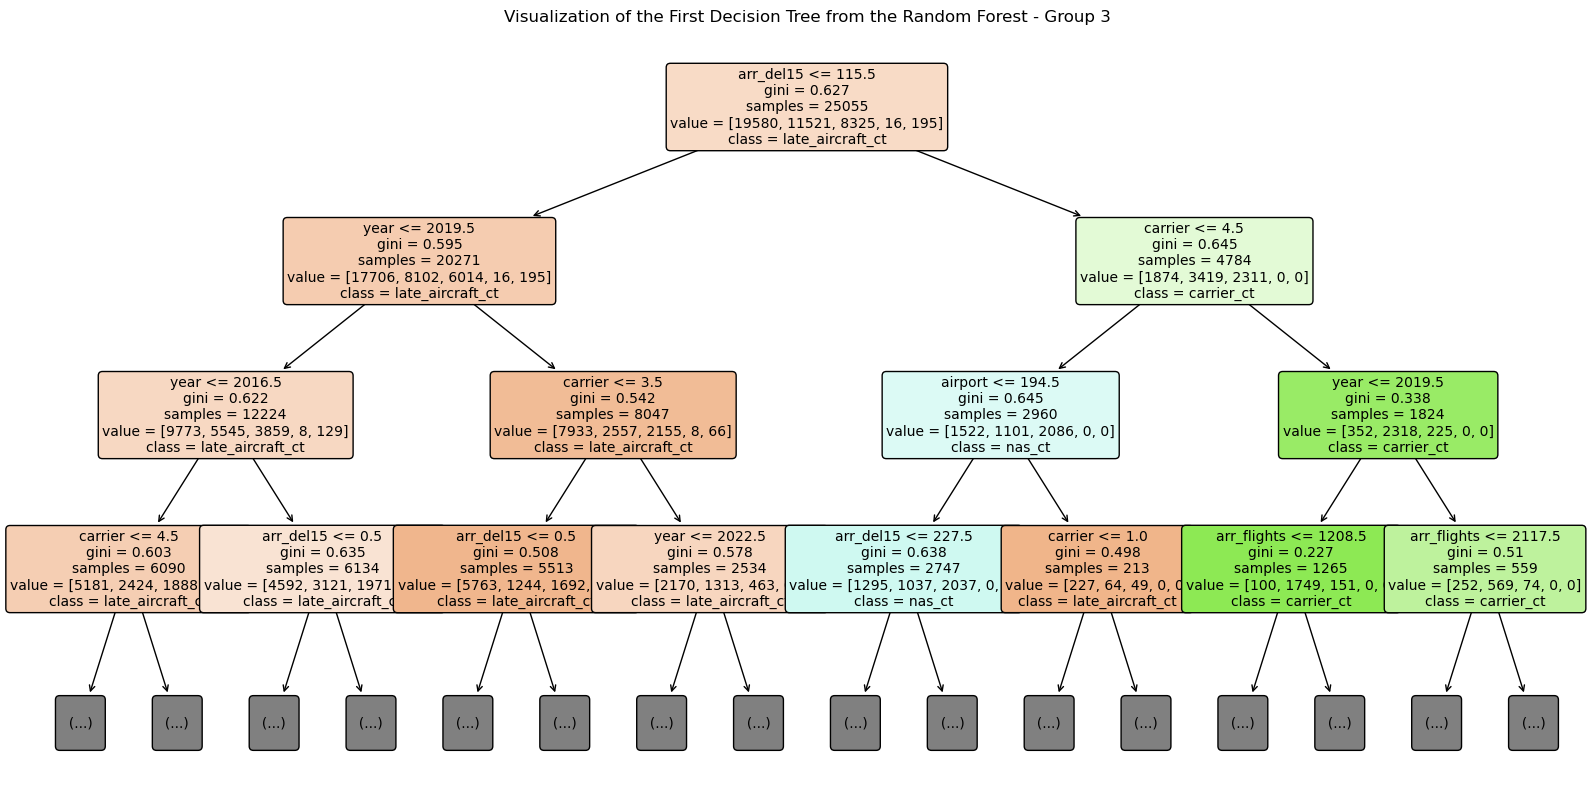

In [29]:
# Visualize the first decision tree from the Random Forest (Group 3)
plt.figure(figsize=(20, 10))
plot_tree(
    best_rf_model.estimators_[0],
    feature_names=X.columns,
    class_names=y.unique(),
    filled=True, 
    rounded=True,
    fontsize=10,
    max_depth=3
)
plt.title("Visualization of the First Decision Tree from the Random Forest - Group 3")
plt.show()

Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Training Accuracy: 0.6477596598607672

Test Accuracy: 0.5802653709586993

Classification Report:
                   precision    recall  f1-score   support

      carrier_ct       0.59      0.74      0.66      2236
late_aircraft_ct       0.55      0.59      0.57      1776
          nas_ct       0.62      0.32      0.42      1268
     security_ct       0.00      0.00      0.00         1
      weather_ct       0.00      0.00      0.00        70

        accuracy                           0.58      5351
       macro avg       0.35      0.33      0.33      5351
    weighted avg       0.58      0.58      0.56      5351



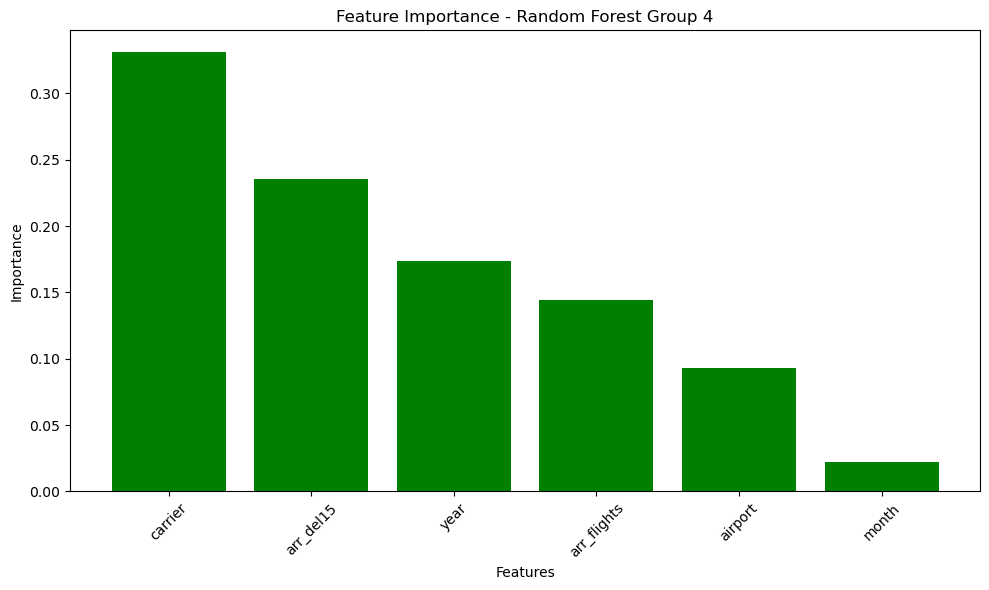

In [32]:
# Group 4 (Non-Top Airlines + Holiday Season)
data = pd.read_csv("Airline_Delay_Cause.csv")

non_top_airlines = ['9E', 'F9', 'G4', 'HA', 'MQ', 'NK', 'OH', 'OO', 'QX', 'YV', 'EV', 'VX', 'US', 'FL', 'YX']
holiday_months = [7, 8, 12]

data = data[data['carrier'].isin(non_top_airlines) & data['month'].isin(holiday_months)].copy()

delay_cols = ['carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct']
data[delay_cols] = data[delay_cols].fillna(0)
data['delay_reason'] = data[delay_cols].idxmax(axis=1)

X = data[['year', 'month', 'arr_flights', 'arr_del15', 'carrier', 'airport']]
y = data['delay_reason']

threshold = 2
rare_classes = y.value_counts()[y.value_counts() < threshold].index
y = y.replace(rare_classes, 'Other')

min_samples = 5
valid_classes = y.value_counts()[y.value_counts() >= min_samples].index
filtered_indices = y.index[y.isin(valid_classes)]

X = X.loc[filtered_indices.intersection(X.index)]
y = y.loc[filtered_indices.intersection(y.index)]

num_cols = X.select_dtypes(include=['float64', 'int64']).columns
imputer_num = SimpleImputer(strategy='median')
X.loc[:, num_cols] = imputer_num.fit_transform(X[num_cols])

categorical_cols = ['carrier', 'airport']
label_encoders = {col: LabelEncoder() for col in categorical_cols}

for col in categorical_cols:
    X.loc[:, col] = label_encoders[col].fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini']
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=11),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=2,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)

best_params_rf = grid_search_rf.best_params_
best_rf_model = grid_search_rf.best_estimator_

print("\nBest Hyperparameters:", best_params_rf)

y_pred_rf_train = best_rf_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_rf_train)
print("\nTraining Accuracy:", train_accuracy)

y_pred_rf = best_rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_rf)
print("\nTest Accuracy:", test_accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))

feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importances['feature'], feature_importances['importance'], color='green')
plt.title("Feature Importance - Random Forest Group 4")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

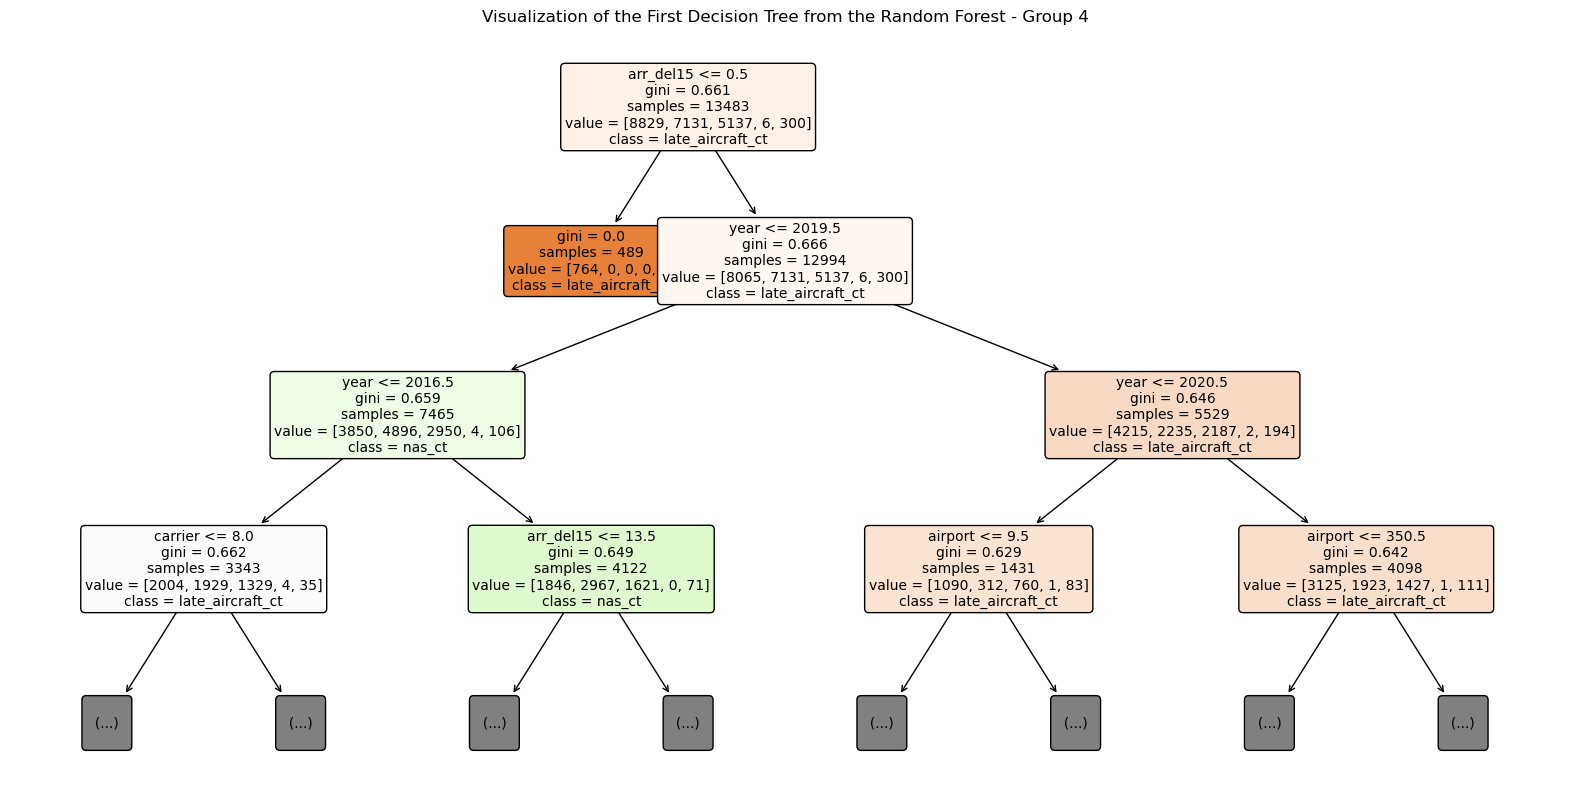

In [33]:
# Visualize the first decision tree from the Random Forest (Group 4)
plt.figure(figsize=(20, 10))
plot_tree(
    best_rf_model.estimators_[0],
    feature_names=X.columns,
    class_names=y.unique(),
    filled=True, 
    rounded=True,
    fontsize=10,
    max_depth=3
)
plt.title("Visualization of the First Decision Tree from the Random Forest - Group 4")
plt.show()